In [1]:
import secrets, base64, qrcode, time, struct, hmac, hashlib

### Generate a secret key

In [6]:
def generate_secret(length: int = 20):
    secret_bytes = secrets.token_bytes(length)
    #Convert to base32
    base32 = base64.b32encode(secret_bytes).decode('utf-8')
    return secret_bytes, base32

### Genrate a URI


In [17]:
def generate_totp_uri(

    label: str = "SmartLock:contact@aneeshpatne.com",
    issuer: str = "Aneesh",
    base32: str = "4JQK4O2T6M25WCPA2PPSTXYEOFUVNR5H",
    algo: str = "SHA1",
    digits: int = 6,
    period: int = 5
) -> str:
    return f"otpauth://totp/{label}?secret={base32}&issuer={issuer}&algorithm={algo}&digits={digits}&period={period}"



In [18]:
secret_bytes, base32 = generate_secret()
# print(secret_bytes, base32)
URI = generate_totp_uri()
# URI

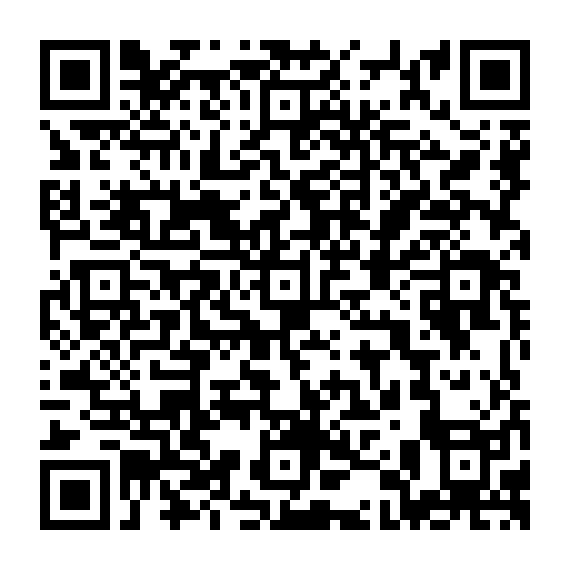

In [19]:
qrcode.make(URI)